<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

## _*Getting Started with QISKit*_ 

The latest version of this notebook is available on https://github.com/QISKit/qiskit-tutorial.

***
### Contributors
Jay Gambetta, Ismael Faro, Andrew Cross, Ali Javadi

## QISKit (Quantum Information Science Kit)

This tutorial aims to explain how to use QISKit. We assume you have installed QISKit if not please look at [qiskit.org](http://www.qiskit.org) or the install [documentation](https://github.com/QISKit/qiskit-tutorial/blob/master/INSTALL.md). 

QISKit is a Python software development kit that you can use to create your quantum computing programs based on circuits defined through the [OpenQASM](https://github.com/QISKit/qiskit-openqasm) specification and execute them on several backends (real quantum processors online, simulators online, and simulators on local). For the online backends conects to the [IBM Q Experience project](http://quantumexperience.ng.bluemix.net/).

In addition to this tutorial, we have other tutorials that introduce you to more complex concepts directly related to quantum computing.

More examples:
- Familiarize yourself with the important concepts of [superposition and entanglement](../qis/superposition_and_entanglement.ipynb).

In [1]:
import sys, time
try:
    sys.path.append("../../") # go to parent dir
    import Qconfig
    qx_config = {
        "APItoken": Qconfig.APItoken,
        "url": Qconfig.config['url']}
except:
    qx_config = {
        "APItoken":"YOUR_TOKEN_HERE",
        "url":"https://quantumexperience.ng.bluemix.net/api"}

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, QISKitError
from qiskit import available_backends, execute, register, get_backend

## Basic Concept

The basic concept of our QISKit core is an array of quantum circuits. The workflow consists of three stages: [Build](#sectionB), [Compile](#sectionC), and [Run](#sectionR). Build allows you to make different quantum circuits that represent the problem you are solving; Compile allows you to rewrite them to run on different backends (simulators/real chips of different [quantum volumes](http://ibm.biz/qiskit-quantum-volume), sizes, fidelity, etc); and Run launches the jobs.  After the jobs have been run, the data is collected. There are methods for putting this data together, depending on the program. This either gives you the answer you wanted, or allows you to make a better program for the next instance.

### Building your circuit: Create it  <a id='sectionB'></a>

The basic elements needed for your first program are the QuantumCircuit, QuantumRegister, and ClassicalRegister.

In [3]:
# Create a Quantum Register called "q" with 3 qubits
qr = QuantumRegister(3)

# Create a Classical Register called "c" with 3 bits
cr = ClassicalRegister(3)

# Create a Quantum Circuit called involving "qr" and "cr"
circuit = QuantumCircuit(qr, cr)

After you create the circuit with its registers, you can add gates to manipulate the registers. As you proceed though the tutorial you will find more quantum gates and circuits but the below is an example of the quantum half adder.

In [4]:
# Not gate on qubit 0
circuit.x(qr[0])

# Not gate on qubit 1
circuit.x(qr[1])

# Barrier to seperator the input from the circuit
circuit.barrier(qr[0])
circuit.barrier(qr[1])
circuit.barrier(qr[2])

# Toffoli gate from qubit 0,1 to qubit 2
circuit.ccx(qr[0], qr[1], qr[2])

# CNOT (Controlled-NOT) gate from qubit 0 to qubit 1
circuit.cx(qr[0], qr[1])

# measure gate from qr to cr
circuit.measure(qr, cr)

### Extract OpenQASM

You can obtain a OpenQASM representation of your code.

In [5]:
# QASM from a program

QASM_source = circuit.qasm()

print(QASM_source)

OPENQASM 2.0;
include "qelib1.inc";
qreg q0[3];
creg c0[3];
x q0[0];
x q0[1];
barrier q0[0];
barrier q0[1];
barrier q0[2];
ccx q0[0],q0[1],q0[2];
cx q0[0],q0[1];
measure q0[0] -> c0[0];
measure q0[1] -> c0[1];
measure q0[2] -> c0[2];



### Visualize Circuit

You can visualize your circuit using QISKit's `circuit_drawer`, which plots the unrolled circuit in the specified basis.

NOTE: To get this to work you need to make sure poppler is installed.

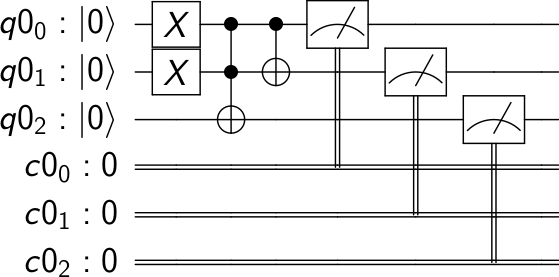

In [6]:
from qiskit.tools.visualization import circuit_drawer
circuit_drawer(circuit)

### Execute <a id='sectionC'></a>

First we need to choose the backend. Lets start with the local simulator 

In [7]:
backend = 'local_qasm_simulator' 

Next we need to run the circuit

In [8]:
# Create a Quantum Program for execution 
job = execute(circuit, backend)

Execute compiles and runs the circuits

```
execute(name_of_circuits=None, backend='local_qasm_simulator', config=None, basis_gates=None, coupling_map=None, initial_layout=None, shots=1024, max_credits=3, seed=None, qobj_id=None, hpc=None, skip_translation=False)
```

(**Tip**: You can obtain the above parameters in Jupyter. Simply place the text cursor on a function and press Shift+Tab)

When you run a program a job object is made

```
job.status
```
returns the status of the job

```
job.done
``` 
is a bool the returns the Ture if the job is done

```
job.cancel
``` 
cancels the job

```
job.result()
``` 
returns the job result object

In [9]:
job.status

{'status': <JobStatus.DONE: 'job has successfully run'>, 'status_msg': None}

In [10]:
result = job.result()

### Result
You can access the result via the function 

```get_counts(circuit)```. 

In [11]:
result.get_counts(circuit)

{'101': 1024}

### Execute on a Real Device<a id='sectionR'></a>

To run it on a real device we need to register the IBMQ backends. For the public devices this can be done using 

```
register(args,...)
```

In [12]:
register(qx_config['APItoken'], qx_config['url'])

In [13]:
def lowest_pending_jobs():
    """Returns the backend with lowest pending jobs."""
    list_of_backends = available_backends(
        {'local': False, 'simulator': False})
    device_status = [get_backend(backend).status
                     for backend in list_of_backends]

    best = min([x for x in device_status if x['available'] is True],
               key=lambda x: x['pending_jobs'])
    return best['name']

In [14]:
backend = lowest_pending_jobs()
print("the best backend is " + backend)

the best backend is ibmqx4


In [15]:
shots = 1024           # Number of shots to run the program (experiment); maximum is 8192 shots.
max_credits = 3          # Maximum number of credits to spend on executions. 

job_exp = execute(circuit, backend=backend, shots=shots, max_credits=max_credits)

In [16]:
lapse = 0
interval = 10
while not job_exp.done:
    print('Status @ {} seconds'.format(interval * lapse))
    print(job_exp.status)
    time.sleep(interval)
    lapse += 1
print(job_exp.status)

Status @ 0 seconds
{'job_id': None, 'status': <JobStatus.INITIALIZING: 'job is being initialized'>, 'status_msg': 'job is begin initialized please wait a moment'}
Status @ 10 seconds
{'job_id': '41165f741553cfd52fc53a8618ff9abe', 'queue_position': 3, 'status': <JobStatus.QUEUED: 'job is queued'>, 'status_msg': None}
Status @ 20 seconds
{'job_id': '41165f741553cfd52fc53a8618ff9abe', 'queue_position': 3, 'status': <JobStatus.QUEUED: 'job is queued'>, 'status_msg': None}
Status @ 30 seconds
{'job_id': '41165f741553cfd52fc53a8618ff9abe', 'queue_position': 3, 'status': <JobStatus.QUEUED: 'job is queued'>, 'status_msg': None}
Status @ 40 seconds
{'job_id': '41165f741553cfd52fc53a8618ff9abe', 'queue_position': 3, 'status': <JobStatus.QUEUED: 'job is queued'>, 'status_msg': None}
Status @ 50 seconds
{'job_id': '41165f741553cfd52fc53a8618ff9abe', 'status': <JobStatus.RUNNING: 'job is actively running'>, 'status_msg': None}
Status @ 60 seconds
{'job_id': '41165f741553cfd52fc53a8618ff9abe', 'stat

In [17]:
result_real = job_exp.result()

Like before, the counts from the execution can be obtained using ```get_counts('name')``` 

In [18]:
result_real.get_counts(circuit)

{'000': 35,
 '001': 174,
 '010': 55,
 '011': 32,
 '100': 93,
 '101': 563,
 '110': 45,
 '111': 27}

The job ID can be obtained using the following which you can use later to get the job if your experiment takes longer to run then you have time to wait around.

In [19]:
jobID = job_exp.job_id

print('JOB ID: {}'.format(jobID))        

JOB ID: 41165f741553cfd52fc53a8618ff9abe


In [20]:
jobID

'41165f741553cfd52fc53a8618ff9abe'